# Kalman Filter, Kalman Smoother, Garch, Garch-t & Mooving Average

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xlrd
from scipy.optimize import minimize
import pandas as pd
import scipy.special as ss

In [3]:
# Importing data
df=pd.read_excel('NFLX.xlsx',skipinitialspace=True)

In [4]:
T=120
'''Feature Engineering'''

df['AvgOC']=(df['Open']+df['Close'])/2
df['AvgHL']=(df['High']+df['Low'])/2
df['logValue']=np.log(df['Close'])
df['LV']=np.log(df['Volume'])
df['AllTotal']=(df['Open']+df['Close']+df['High']+df['Low'])/4
df['LogTotal']=np.log(df['AllTotal'])
df.head()

Date    Open    High     Low   Close  Volume    AvgOC    AvgHL  \
0 2016-01-04  111.55  111.75  105.21  110.15  188288  110.850  108.480   
1 2016-01-05  109.01  111.20  105.85  107.67  160849  108.340  108.525   
2 2016-01-06  105.45  118.45  104.50  118.25  307273  111.850  111.475   
3 2016-01-07  118.30  122.18  112.29  114.45  311756  116.375  117.235   
4 2016-01-08  116.00  117.72  111.00  111.01  164152  113.505  114.360   

   logValue         LV  AllTotal  LogTotal  
0  4.701843  12.145728  109.6650  4.697430  
1  4.679071  11.988221  108.4325  4.686128  
2  4.772801  12.635492  111.6625  4.715481  
3  4.740138  12.649976  116.8050  4.760506  
4  4.709620  12.008548  113.9325  4.735606

In [5]:
Y = (df['Open'] + df['Close'])/2

## Kalman Filter & Smoother

D:\Prgrams\lib\site-packages\ipykernel_launcher.py:82: OptimizeWarning: Unknown solver options: xtol


Optimization terminated successfully.
         Current function value: 3.848048
         Iterations: 3
         Function evaluations: 42
         Gradient evaluations: 7


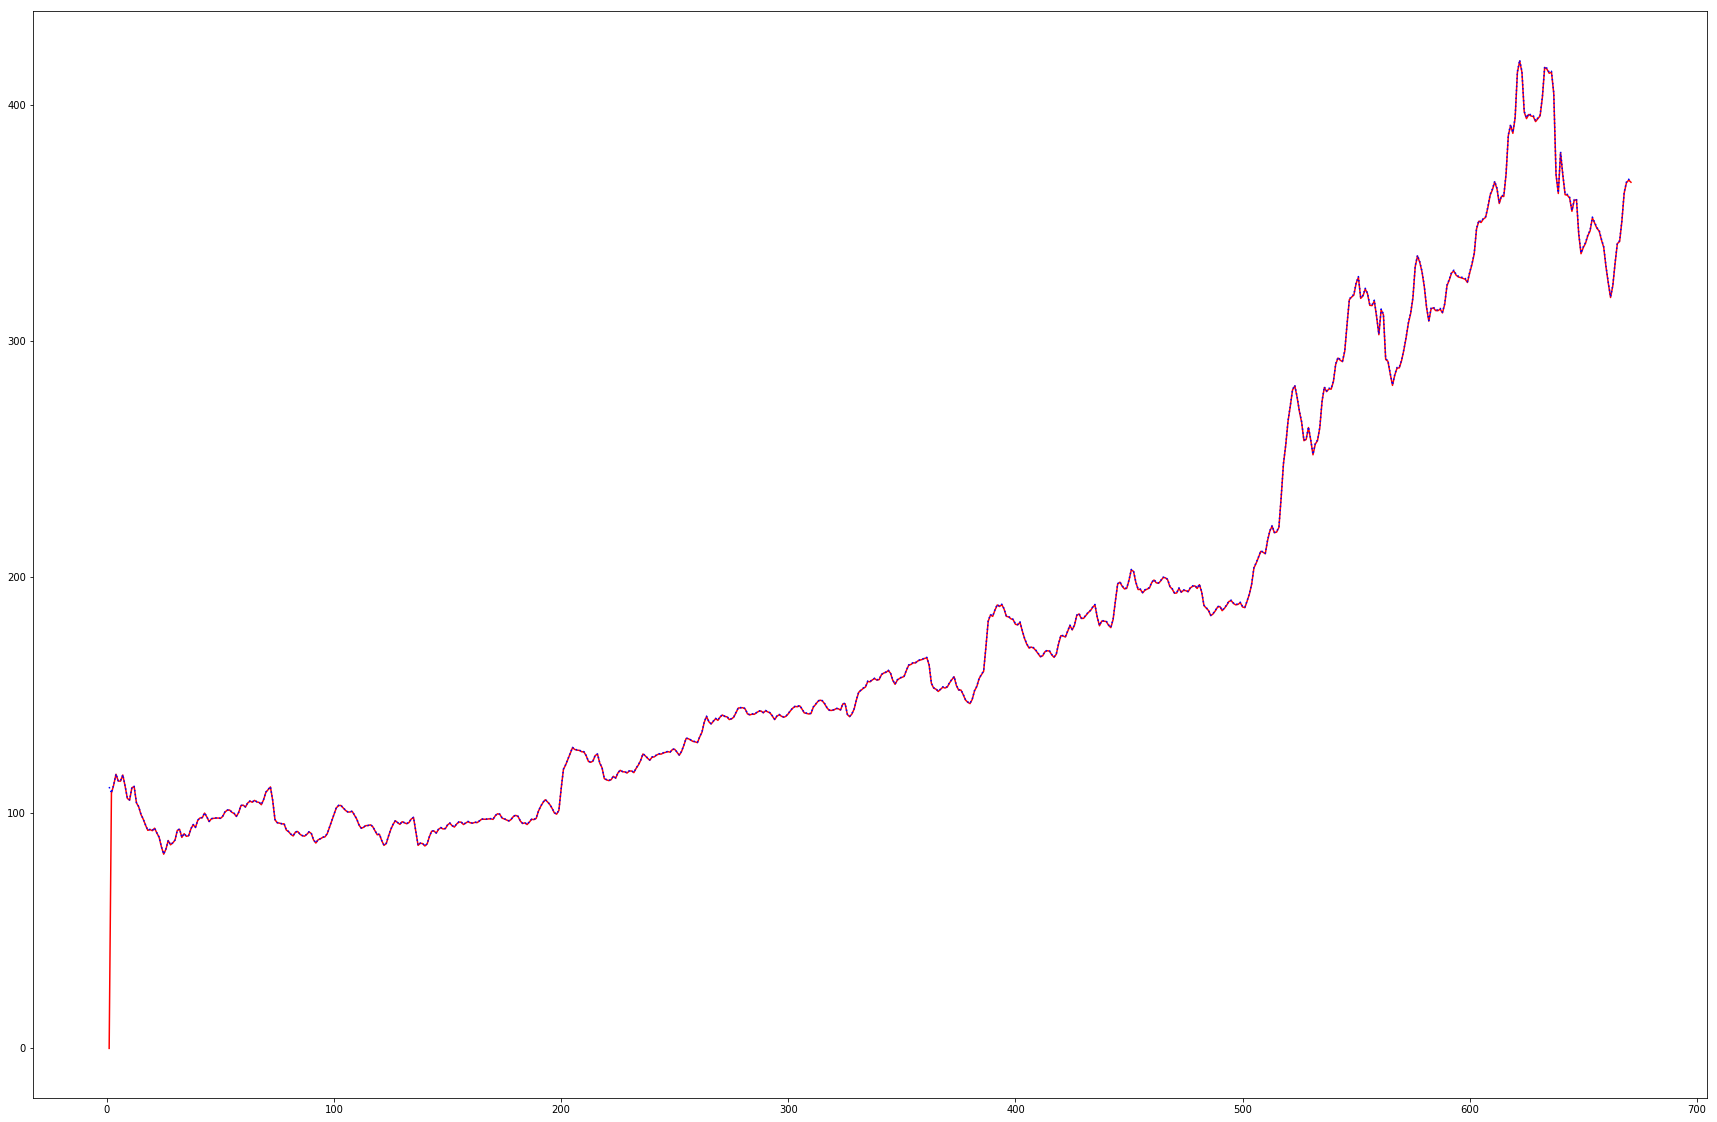

In [6]:
def Kalman_Filter(Y):
 S = Y.shape[0]
 S = S + 1
# "Initialize Params:"
 Z = param0[0]
 T = param0[1]
 H = param0[2]
 Q = param0[3]
# "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
    Likelihood = np.sum(KF_Dens[1:-1])  
    return Likelihood


def Kalman_Smoother(params, Y):
 S = Y.shape[0]
 S = S + 1
# "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 
# "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[0:-1]
 return u_smooth

T = 671
df['AvgOC']=(df['Open']+df['Close'])/2
df['AvgHL']=(df['High']+df['Low'])/2
df['logValue']=np.log(df['Close'])
df['LV']=np.log(df['Volume'])
df['AllTotal']=(df['Open']+df['Close']+df['High']+df['Low'])/4
df['LogTotal']=np.log(df['AllTotal'])
Y = df['AvgOC']
#Y = (df['Open '] + df['Close'])/2
#Y = np.random.normal(0,1,T)
param0 = np.array([1, .5, .1, 100])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_update = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.rcParams['figure.figsize'] = (30.0, 20.0)
plt.plot(timevec, Y_update,'r',timevec, Y,'b:')


Optimization terminated successfully.
         Current function value: 3.848048
         Iterations: 3
         Function evaluations: 42
         Gradient evaluations: 7


D:\Prgrams\lib\site-packages\ipykernel_launcher.py:75: OptimizeWarning: Unknown solver options: xtol


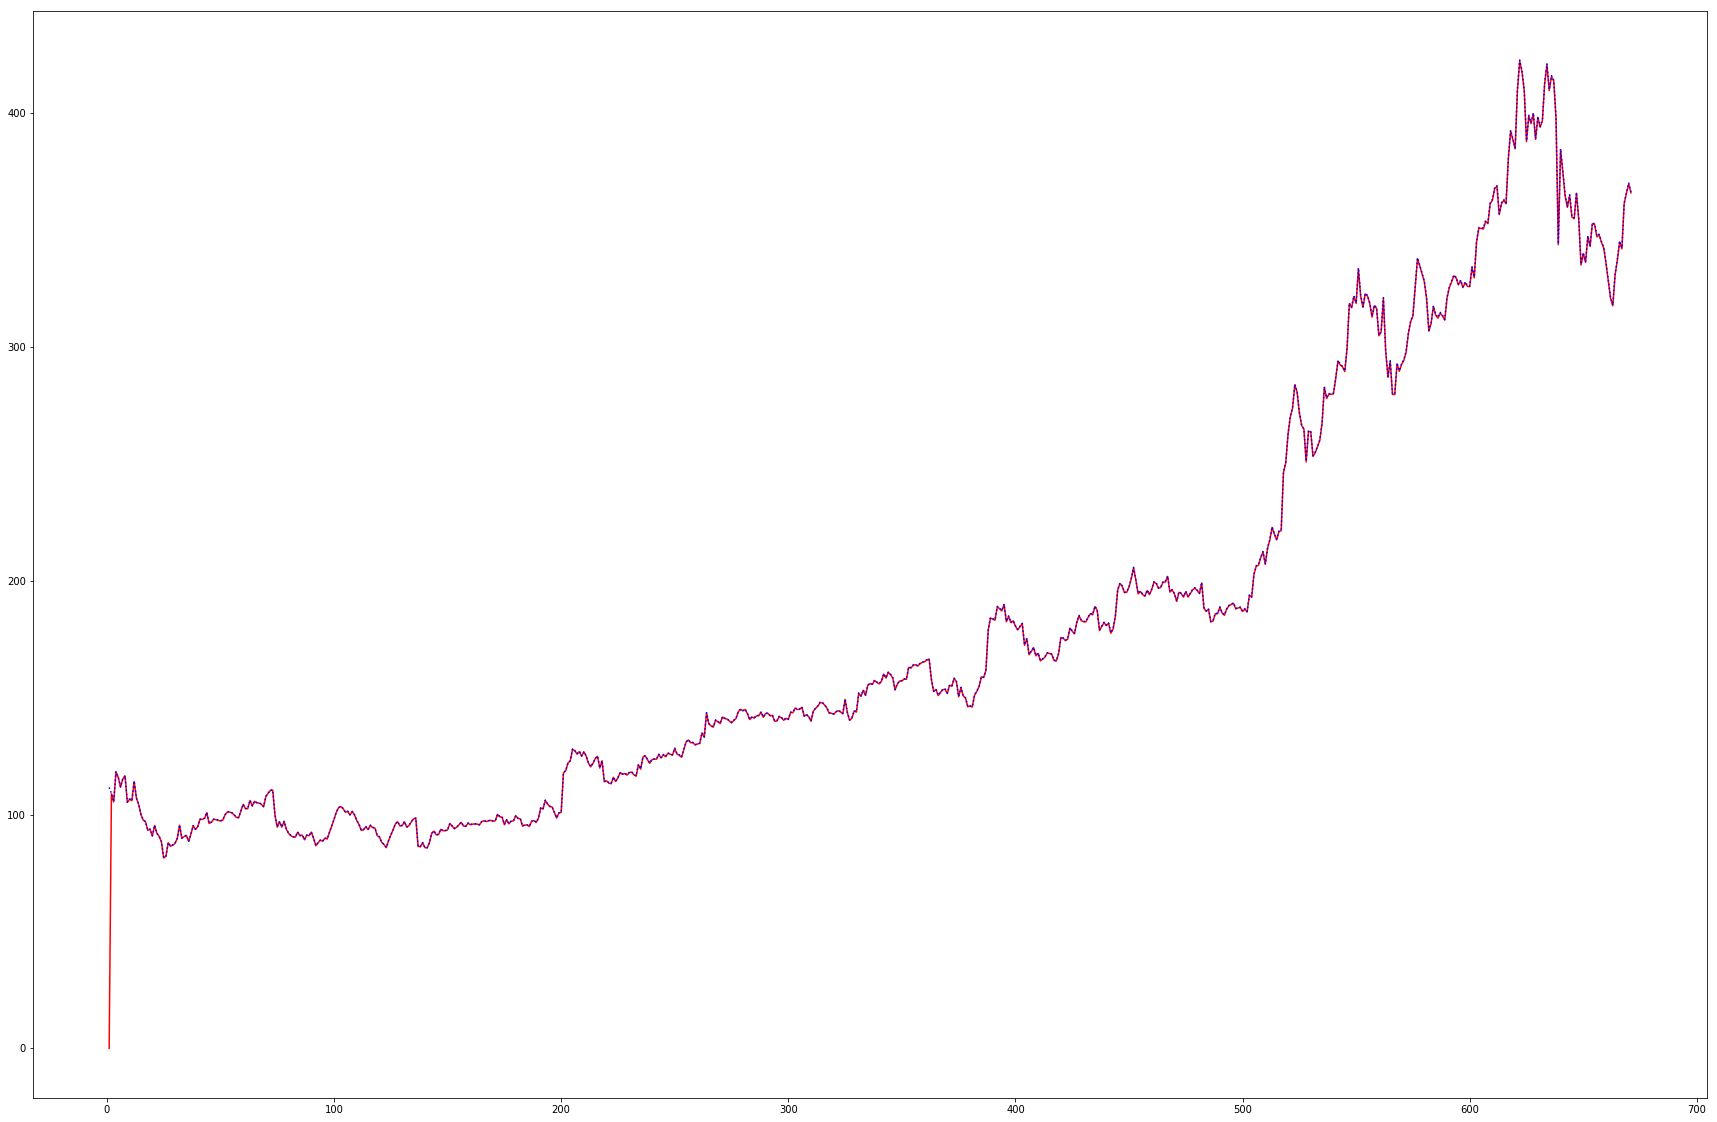

In [7]:
def Kalman_Filter(Y):
 S = Y.shape[0]
 S = S + 1
# "Initialize Params:"
 Z = param0[0]
 T = param0[1]
 H = param0[2]
 Q = param0[3]
# "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 KF_Dens = np.zeros(S)
 for s in range(1,S):
  if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
  else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    KF_Dens[s] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]     
    Likelihood = np.sum(KF_Dens[1:-1])  
    return Likelihood


def Kalman_Smoother(params, Y):
 S = Y.shape[0]
 S = S + 1
# "Initialize Params:"
 Z = params[0]
 T = params[1]
 H = params[2]
 Q = params[3]
 
# "Kalman Filter Starts:"
 u_predict = np.zeros(S)
 u_update = np.zeros(S)
 P_predict = np.zeros(S)
 P_update = np.zeros(S)
 v = np.zeros(S)
 F = np.zeros(S)
 for s in range(1,S):
   if s == 1: 
    P_update[s] = 1000
    P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
   else: 
    F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
    v[s]=Y[s-1]-Z*u_predict[s-1]   
    u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
    u_predict[s] = T*u_update[s]; 
    P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1];
    P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth = np.zeros(S)
    P_smooth = np.zeros(S)
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
 for  t in range(S-1,0,-1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[t])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
 u_smooth = u_smooth[0:-1]
 return u_smooth

T = 671
Y = (df['Open'])
#Y = np.random.normal(0,1,T)
param0 = np.array([1, .5, .1, 100])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_update = Kalman_Smoother(param_star.x, Y)
timevec = np.linspace(1,T,T)
plt.rcParams['figure.figsize'] = (30.0, 20.0)
plt.plot(timevec, Y_update,'r',timevec, Y,'b:')


## Garch & Garch-t

In [8]:
#likelihood function Garch
def GARCH(Y):
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    sigma2[0] = omega/(1-alpha)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t];
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+\
                     (1/2)*(F[t]/v[t]);
        Likelihood = np.sum(GARCH_Dens[1:-1])
        return Likelihood

In [9]:
#likelihood function Garch-t
def GARCH_t(Y):
    mu = param0[0]
    omega = np.exp(param0[1])
    alpha = 1/(1+np.exp(-param0[2]))
    beta = param0[3]
    nv = param0[4]
    
    T = Y.shape[0]
    GARCH_t_dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    V = np.zeros(T)
    sigma2[0] = omega/(1-alpha)
    
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.standard_t(nv,1)
        V[t] = sigma2[t];
        GARCH_t_dens[t] = np.log(ss.gamma((nv+1)/2))-np.log(np.sqrt(nv*np.pi))-\
                          np.log(ss.gamma(nv/2))-((nv+1)/2)*np.log(1+((F[t]**2)/V[t])/nv)
        Likelihood = np.sum(GARCH_t_dens[1:-1])
        return Likelihood

In [10]:
# Garch
def GARCH_PROD(params, Y0, T):
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    #Y = np.zeros(T)
    Y = df['Open']
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0]= omega/(1-alpha)
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        return Y
    

In [11]:
# Garch-t
def GARCH_PROD_t(params, Y0, T):
    mu = params[0]
    omega = np.exp(params[1])
    alpha = 1/(1+np.exp(-params[2]))
    beta = params[3]
    nv = params[4]
    #Y = np.zeros(T)
    Y = df['Open']
    #Y = (df['Volume'])
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0]= omega/(1-alpha)
    for t in range(1,T):
        sigma2[t] = omega+alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(nv,1)
        return Y

         Current function value: 2.837141
         Iterations: 2
         Function evaluations: 120
         Gradient evaluations: 18


D:\Prgrams\lib\site-packages\ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xtol
  
D:\Prgrams\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Prgrams\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


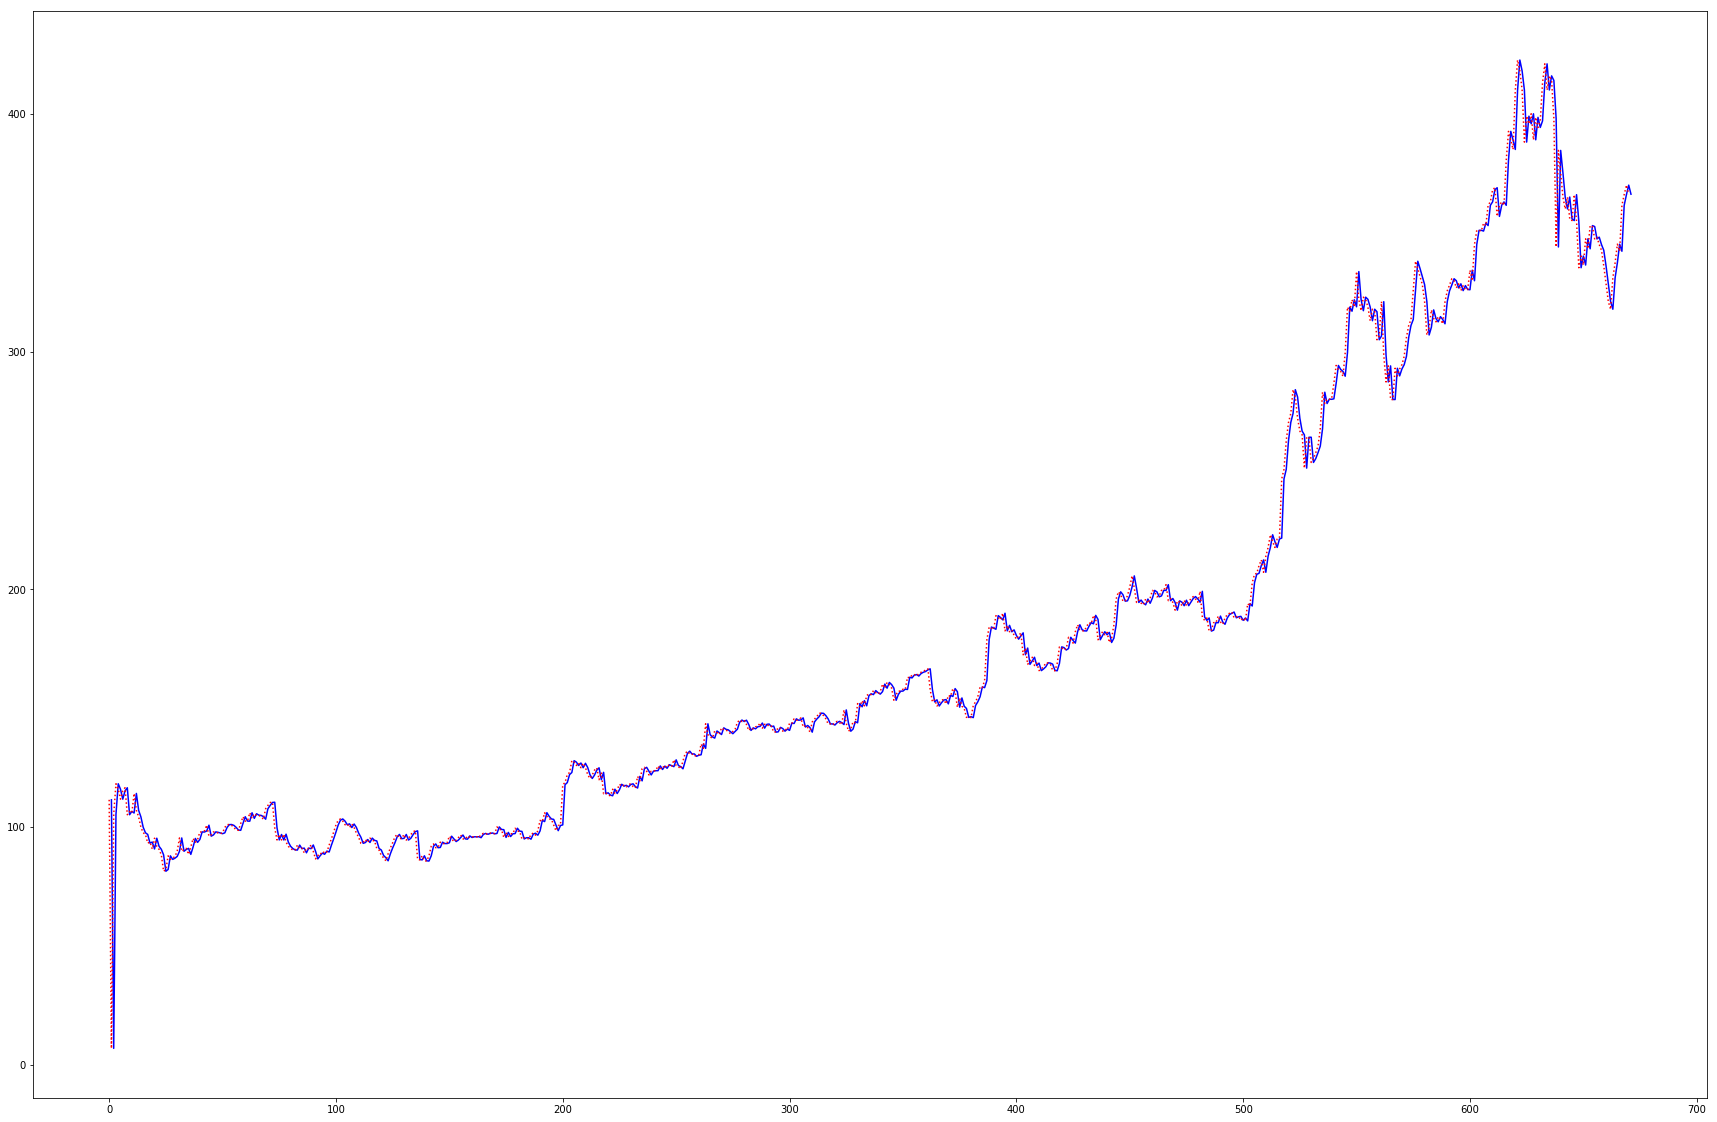

In [12]:
# Garch

T = 671
mu = 35
sig =5
Y = df['Open']
param0 = np.array([32,35,0.2,0.5])
param_star = minimize(GARCH, param0, method ='BFGS', options ={'xtol':1e-8, 'disp':True})
Y_GARCH = GARCH_PROD(param_star.x, Y[0],T)
timevec = np.linspace(1,T,T)
plt.plot(timevec,Y,'b', Y_GARCH,'r:')

D:\Prgrams\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
D:\Prgrams\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


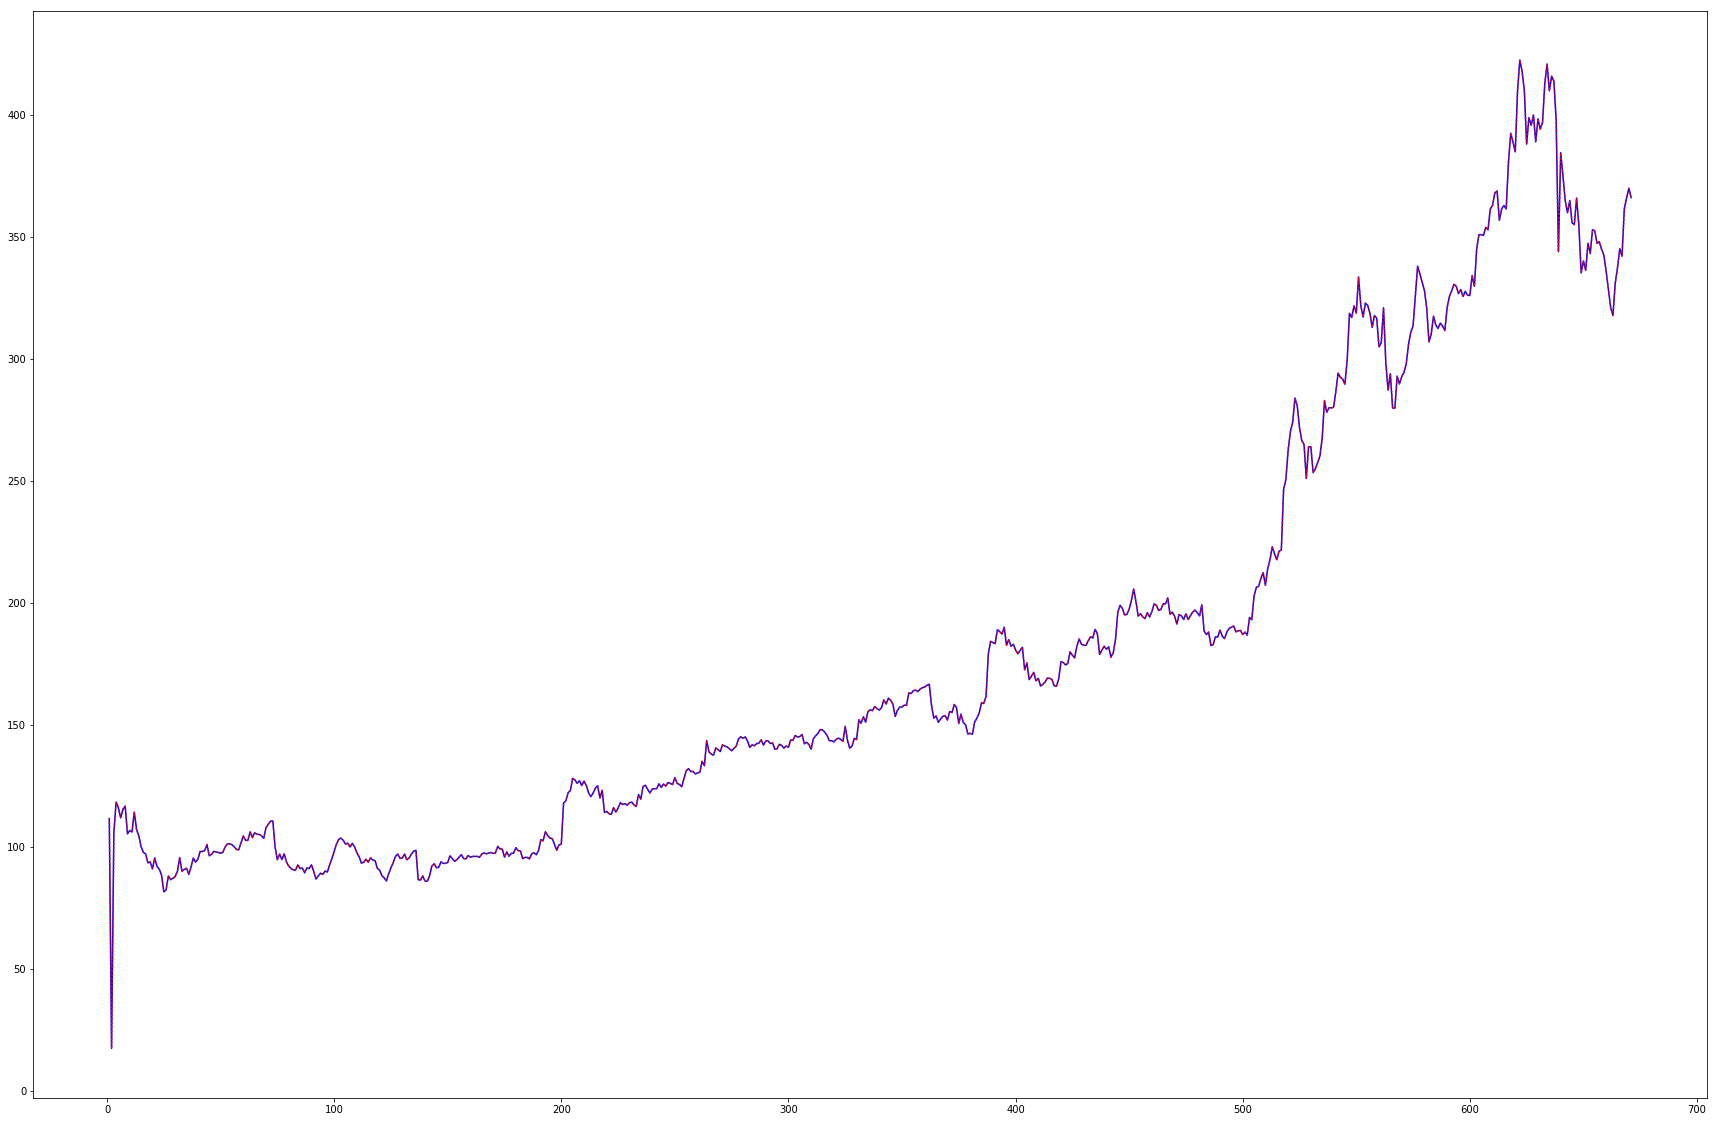

In [13]:
# Garch t


T =671
#df = 4
#Y = np.random.standard_t(df, size = T)
Y = df['Open']
#Y = (df['Volume'])
param0 = np.array([0.1,0.2,2,2,1])
param_star = minimize(GARCH_t, param0, method ='BFGS')
Y_GARCH = GARCH_PROD_t(param_star.x,Y[0],T)
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y, 'b', timevec, Y_GARCH, 'r:')

In [14]:
rmse = np.sqrt

In [15]:
param_star.x

array([0.09997955, 0.19999502, 1.99998701, 2.00002673, 0.9999907 ])

## Moving Average

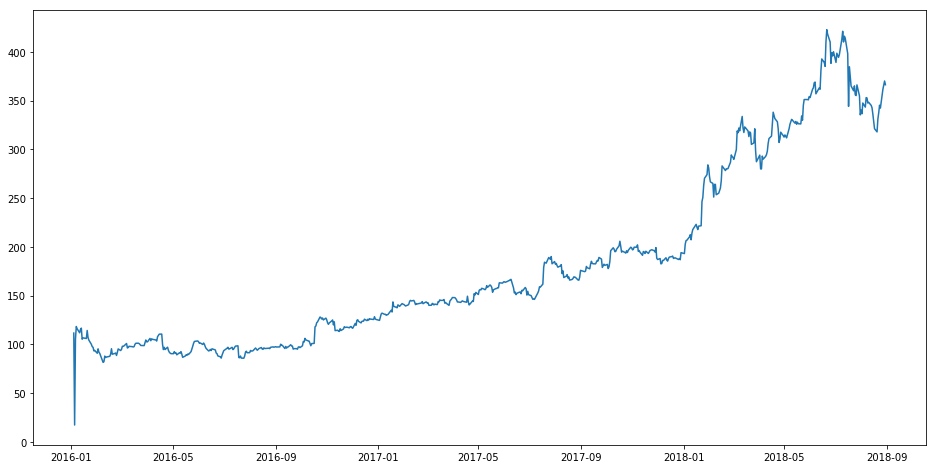

In [16]:
#Moving Average
df['AvgOC']=(df['Open']+df['Close'])/2
df['AvgHL']=(df['High']+df['Low'])/2
df['logValue']=np.log(df['Close'])
df['LV']=np.log(df['Volume'])
df['AllTotal']=(df['Open']+df['Close']+df['High']+df['Low'])/4
df['LogTotal']=np.log(df['AllTotal'])

#Moving Avg
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%d-%b-%y')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Open'], label='Close Price history')

#split into train and validation
train = df[:365]
valid = df[365:]

x_train = train.drop('Open', axis=1)
y_train = train['Open']
x_valid = valid.drop('Open', axis=1)
y_valid = valid['Open']

x = df.drop('Open', axis=1)
y = df['Open']

#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Open'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Open'][i] = data['Open'][i]
    


In [17]:
#splitting into train and validation
train = new_data[:301]
valid = new_data[302:603]

train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2016-01-04 00:00:00'),
 Timestamp('2017-03-14 00:00:00'),
 Timestamp('2017-03-16 00:00:00'),
 Timestamp('2018-05-24 00:00:00'))

In [18]:
def MovingAvg(x, y):
    preds = []
    for i in range(0,301):
        a = df['Open'][len(df)-301+i:].sum() + sum(preds)
        b = a/301
        preds.append(b)
    return preds

In [19]:
#make predictions
preds = []
for i in range(0,301):
    a = train['Open'][len(train)-301+i:].sum() + sum(preds)
    b = a/301
    preds.append(b)

In [20]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Open'])-preds),2)))
rms

113.43439448884615

D:\Prgrams\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Prgrams\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


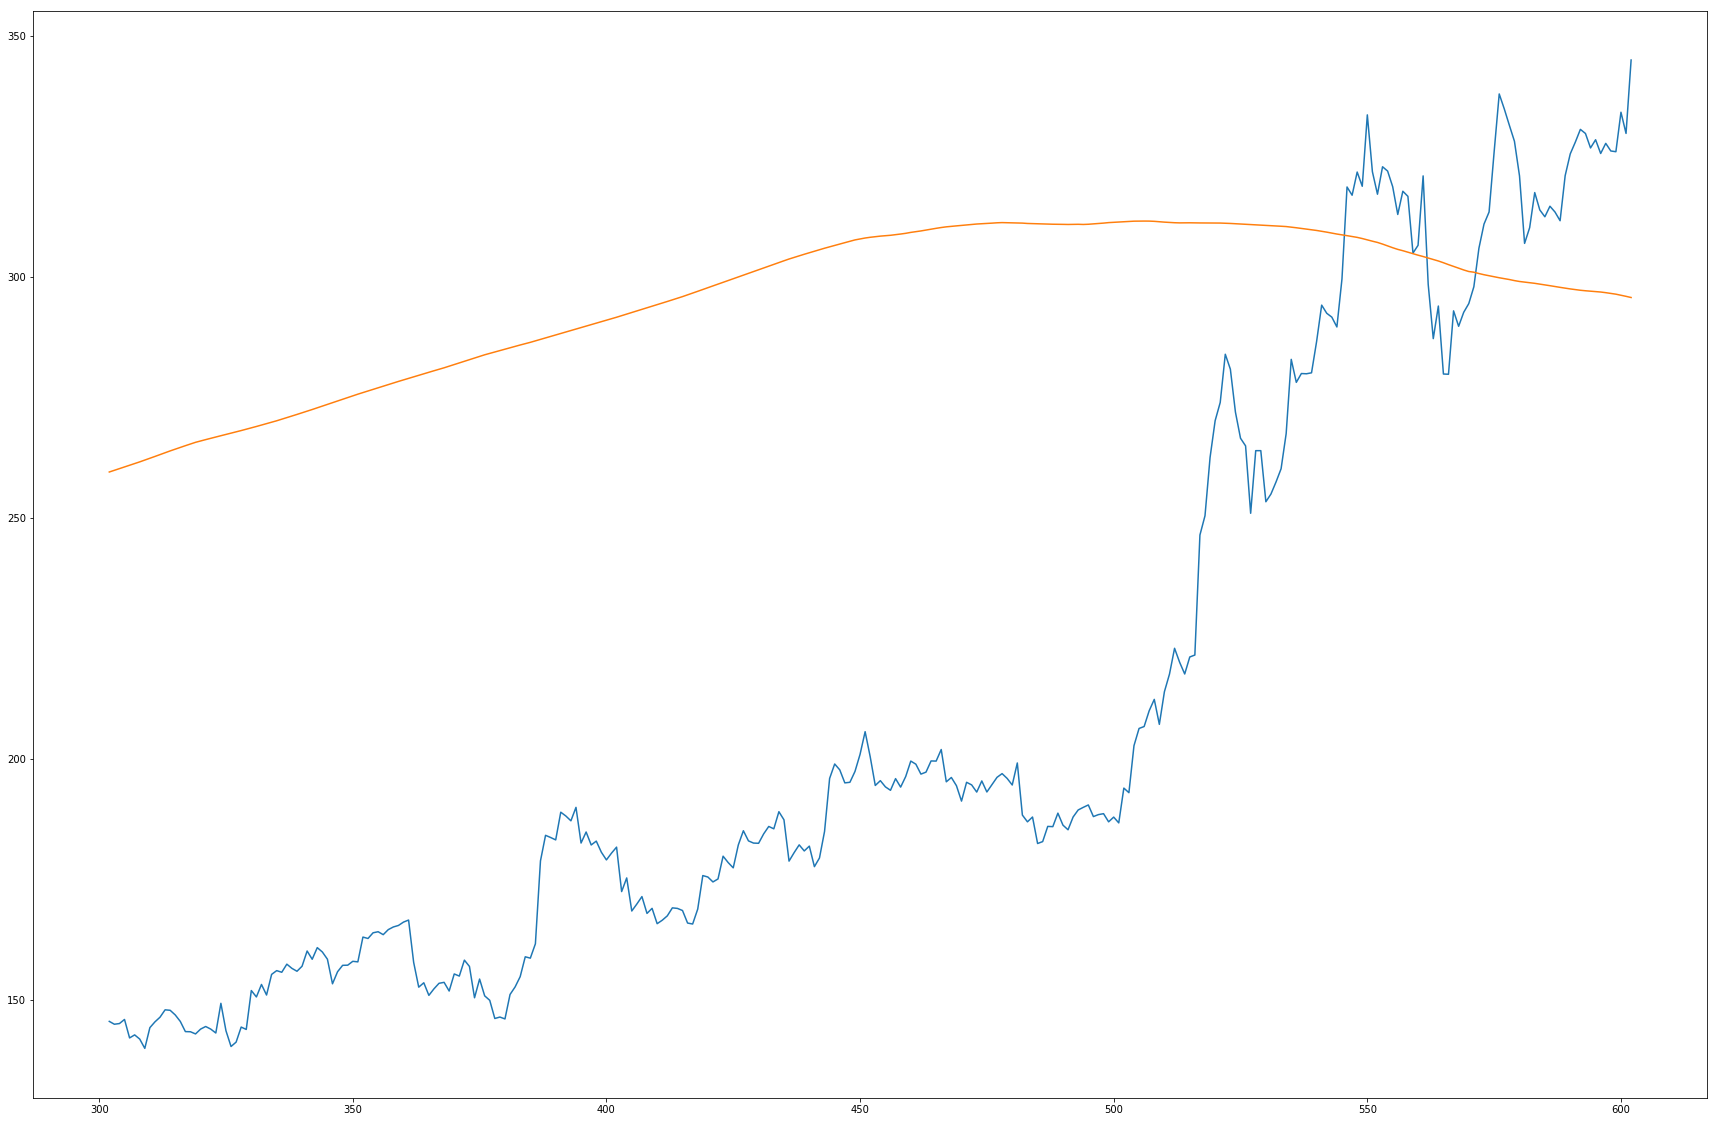

In [21]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = MovingAvg(x,y)
MA = plt.plot(valid[['Open', 'Predictions']])
#plt.plot(train['Open'])
#MA.margins(x=0, y=-0.25)